In [196]:
import numpy
import pandas
import sys
import os

sys.path.append("..")
sys.path.append('../utilities')
import pickling

import matplotlib
import matplotlib.pyplot as plt
% matplotlib inline

import numpy as np
from sklearn import tree

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
import random
from sklearn.metrics import confusion_matrix

In [337]:
df = pandas.read_csv('df.csv', index_col =0 )
df['sex_doctor'] = df['sex_doctor'].apply(lambda x: 0 if x=='F' else 1)
index = list(df.index)
random.seed(777)
random.shuffle(index)
df = df.loc[index]

In [338]:
def binary_target_generation(df):
    df['malignant_pred_birads'] = [0 if x in [0, 1,2,3] else 1 for x in df.BIRADS_label]  
    df['malignant_correction'] = (df['malignant_pred_birads'] == df['malignant'])*1
    return df 

In [229]:
df = binary_target_generation(df)
#df = df.loc[df.BIRADS_label!=0]

In [347]:
df_features = df.drop(['F_L_name', 'SigningMd', 'age_group', 'benign', 'index', 'experience_grouping', 'raw_report'], 1)

In [349]:
df_train, df_test = df_features.iloc[:3000], df_features.iloc[3000:]
print(len(df_test))

906


In [341]:
def write_in_to_txt_for_fasttext(reports, labels):
    text = ''
    for (report, lab) in zip(reports, labels):
        text += report.lower() +  ' __label__' +str(lab) + '\n'
    return text

In [342]:
reports_train = df.loc[df_train.index]['raw_report']
text_train = write_in_to_txt_for_fasttext(list(reports_train), list(df_train.malignant))

In [343]:
reports_test = df.loc[df_test.index]['raw_report']
text_test = write_in_to_txt_for_fasttext(list(reports_test), list(df_test.malignant))

In [345]:
file = open('test.txt','w') 
file.write(text_test) 
file.close()

Feature ranking:
1. feature age (0.674075)
2. feature experience_doctor (0.195672)
3. feature density (0.048217)
4. feature BIRADS_label (0.047139)
5. feature sex_doctor (0.011719)
6. feature with_comparison (0.006698)
7. feature with_family_history (0.004848)
8. feature without_comparison (0.004680)
9. feature pos_family_history (0.003782)
10. feature neg_family_history (0.003169)


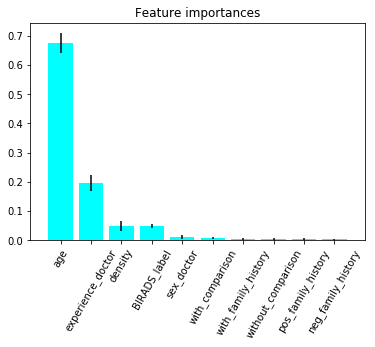

In [350]:
# Build a classification task using 3 informative features

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)
X, y = df_train.drop(['malignant'], 1), df_train.malignant

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)

feature_names = X.columns
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, feature_names[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="cyan", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation = 60)
plt.xlim([-1, X.shape[1]])
plt.show()

In [243]:
import numpy as np

from time import time
from scipy.stats import randint as sp_randint

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier

# get some data

X, y = df_train.drop(['malignant_correction'], 1), df_train['malignant_correction']

# build a classifier
clf = RandomForestClassifier(n_estimators=20)


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# use a full grid over all parameters
param_grid = {"max_depth": [3, 4, 5, 6, 8],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5)
start = time()
grid_search.fit(X, y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

GridSearchCV took 79.74 seconds for 180 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.826 (std: 0.007)
Parameters: {'max_features': 10, 'max_depth': 5, 'bootstrap': True, 'criterion': 'gini', 'min_samples_split': 3}

Model with rank: 1
Mean validation score: 0.826 (std: 0.005)
Parameters: {'max_features': 10, 'max_depth': 3, 'bootstrap': True, 'criterion': 'entropy', 'min_samples_split': 3}

Model with rank: 1
Mean validation score: 0.826 (std: 0.005)
Parameters: {'max_features': 10, 'max_depth': 4, 'bootstrap': True, 'criterion': 'entropy', 'min_samples_split': 10}



In [351]:
clf = RandomForestClassifier(n_estimators=20,
                             max_features= 3, 
                             max_depth= 6, 
                             bootstrap = False, 
                             criterion = 'gini', 
                             min_samples_split = 10)
#clf = ExtraTreesClassifier(n_estimators=150,
#                          random_state=0)

#clf = LogisticRegression(random_state=0,  penalty = 'l1', C = 0.8)

#clf = tree.DecisionTreeClassifier()
clf = clf.fit(df_train.drop(['malignant'], 1), df_train.malignant)

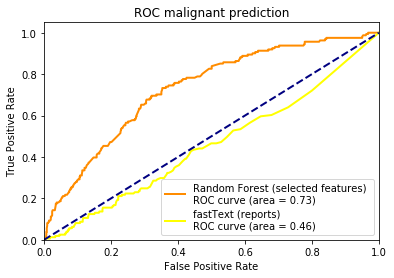

[[744   1]
 [160   1]]
[[681  64]
 [151  10]]


In [352]:
y_score = clf.predict_proba(df_test.drop(['malignant'], 1))

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(df_test['malignant'], y_score[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Random Forest (selected features) \nROC curve (area = %0.2f)' % roc_auc)

file = open('test_prob.txt', 'r')
fasttext_prediction = file.readlines()
fasttext_prob = [1 - float(x.split(' ')[1].replace('\n', '')) if x.split(' ')[0][-1] == '0' else float(x.split(' ')[1].replace('\n', '')) for x in fasttext_prediction]

fpr, tpr, _ = roc_curve(df_test['malignant'], fasttext_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='yellow',
         lw=lw, label='fastText (reports) \nROC curve (area = %0.2f)' % roc_auc)


plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC malignant prediction')
plt.legend(loc="lower right")
plt.show()

y_preb = clf.predict(df_test.drop(['malignant'], 1))
print(confusion_matrix(df_test['malignant'], y_preb))
print(confusion_matrix(df_test['malignant'], [int(x.split(' ')[0][-1]) for x in fasttext_prediction]))

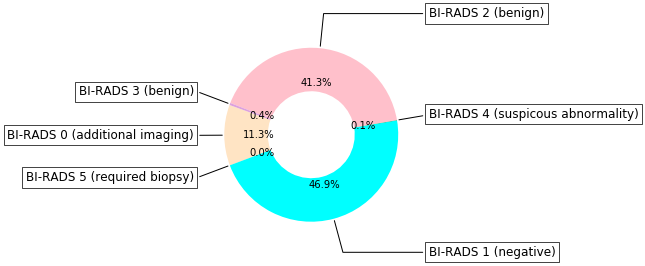

In [329]:
fig, ax = plt.subplots(figsize=(8, 4), subplot_kw=dict(aspect="equal"))

recipe = ["BI-RADS 0 (additional imaging)",
          'BI-RADS 5 (required biopsy)',
          "BI-RADS 1 (negative)",
          "BI-RADS 4 (suspicous abnormality)",
          "BI-RADS 2 (benign)",
          "BI-RADS 3 (benign)",
          ]

data = [25237, 12, 105010, 128, 92531, 874]
#data = [ 4268, 7, 534, 138, 672, 15]

wedges, texts, _ = ax.pie(data, wedgeprops=dict(width=0.5), startangle=160, autopct='%1.1f%%',
                       colors = ['bisque','darkorange','aqua','green', 'pink', 'plum'])

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)

kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, fontsize = 12, **kw)

#ax.set_title("Matplotlib bakery: A donut")

plt.show()

In [280]:
def plot_bars(youngMeans, oldMeans, title, ax, with_tick = True):
    N = 6

    #fig, ax = plt.subplots()

    ind = np.arange(N)    # the x locations for the groups
    width = 0.35         # the width of the bars
    p1 = ax.bar(ind,  np.array(youngMeans) + np.array(oldMeans), width, color='cornflowerblue', bottom=0)

    p2 = ax.bar(ind, youngMeans, width,
                color='aqua', bottom=0)

    ax.set_title(title, fontsize = 10)
    ax.set_xticks(ind + width / 2)
    if with_tick:
        ax.set_xticklabels(('<10 years', '10-20 years', '20-30 years', '>30 years'), fontsize = 10,  rotation = 30)
    else:
        ax.set_xticklabels(('', '', '', ''), fontsize = 10,  rotation = 30)
    ax.legend((p1[0], p2[0]), ('Women with age < 40 ', 'Women with age >= 40 '), fontsize = 10)
    ax.autoscale_view()


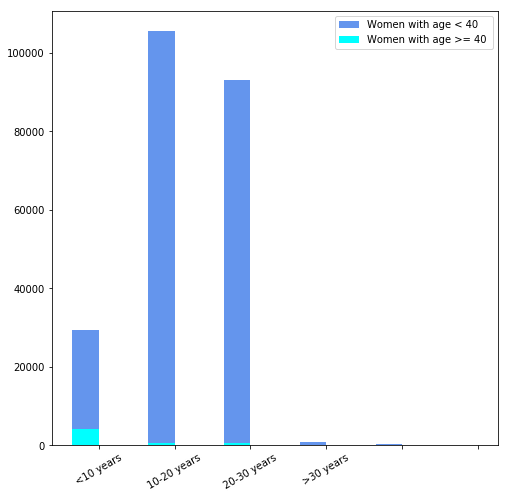

In [281]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize = (8, 8))

plot_bars(with_b,  without_b,  '', axs, with_tick = True)

In [ ]:
p1 = ax.bar(ind,  np.array(youngMeans) + np.array(oldMeans), width, color='cornflowerblue', bottom=0)